In [1]:
import sys
sys.path.append("../lib/")
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2023-09-27 22:44:46.698193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
dataset = "L_540_2022_CERB"
img_path = Path("../img/") / dataset
img_path.mkdir(parents=True, exist_ok=True)
results_path = Path("../results/") / dataset
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))
if "file" in data.columns:
    X = data.drop(columns=["label", "file"])    
else:
    X = data.drop(columns=[""])
wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)
#y = pd.factorize(data.label)[0]
y, unique_labels = pd.factorize(data.label)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [32]:
# Define model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.25), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.25),   
    Dense(y_train.shape[1], activation='softmax')
])
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=250, batch_size=64, 
    verbose=False, callbacks=[EarlyStopping(patience=150)]
                   )
# Evaluate model performance
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=2)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {train_loss}')
print(f'Test accuracy: {train_accuracy}')

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


29/29 - 0s - loss: 0.1510 - accuracy: 0.9933 - 67ms/epoch - 2ms/step
10/10 - 0s - loss: 1.2244 - accuracy: 0.6833 - 40ms/epoch - 4ms/step
Test loss: 1.224413275718689
Test accuracy: 0.6833333373069763
Test loss: 0.15097194910049438
Test accuracy: 0.9933333396911621
10/10 [==============================] - 0s 1ms/step


NameError: name 'model' is not defined

Plot saved to: ../img/L_540_2022_CERB/tf_accuracy.png


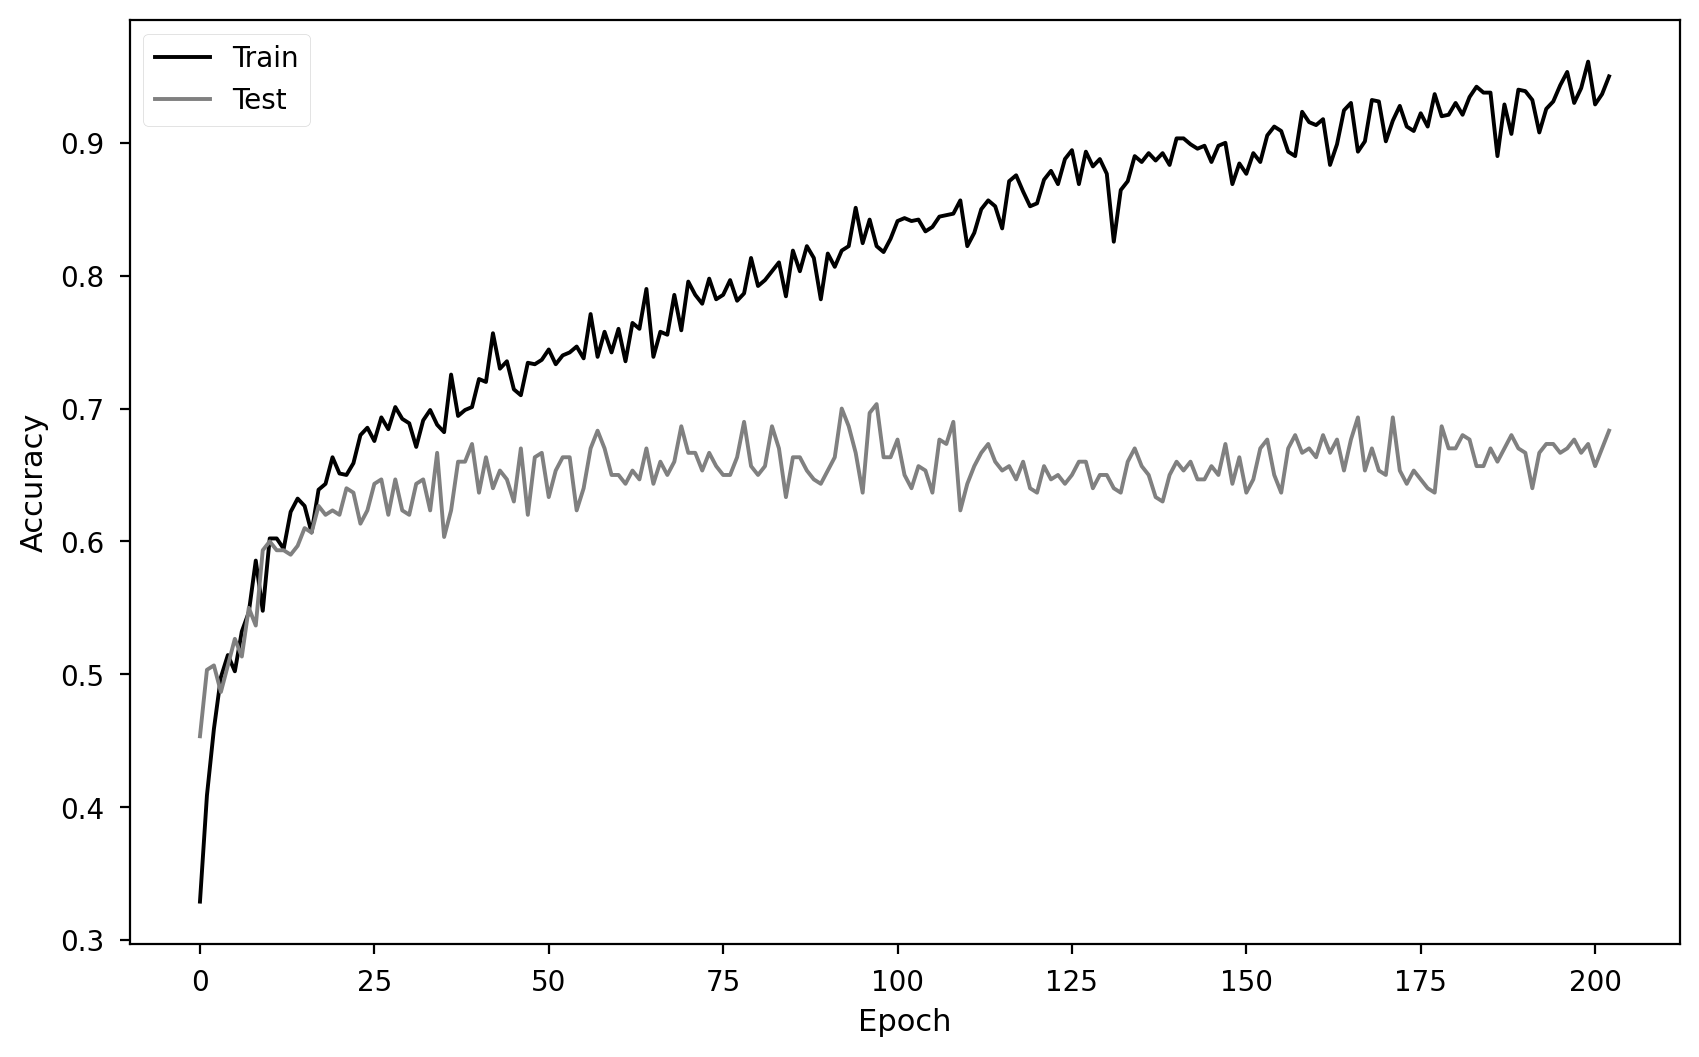

In [33]:
# Create a standalone plot for accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train', color='black')
plt.plot(history.history['val_accuracy'], label='Test', color='gray')
#plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.savefig(img_path / "tf_accuracy.png", format="png", dpi=400, bbox_inches="tight")
print(f"Plot saved to: {img_path / 'tf_accuracy.png'}")

Plot saved to: ../img/L_540_2022_CERB/tf_loss.png


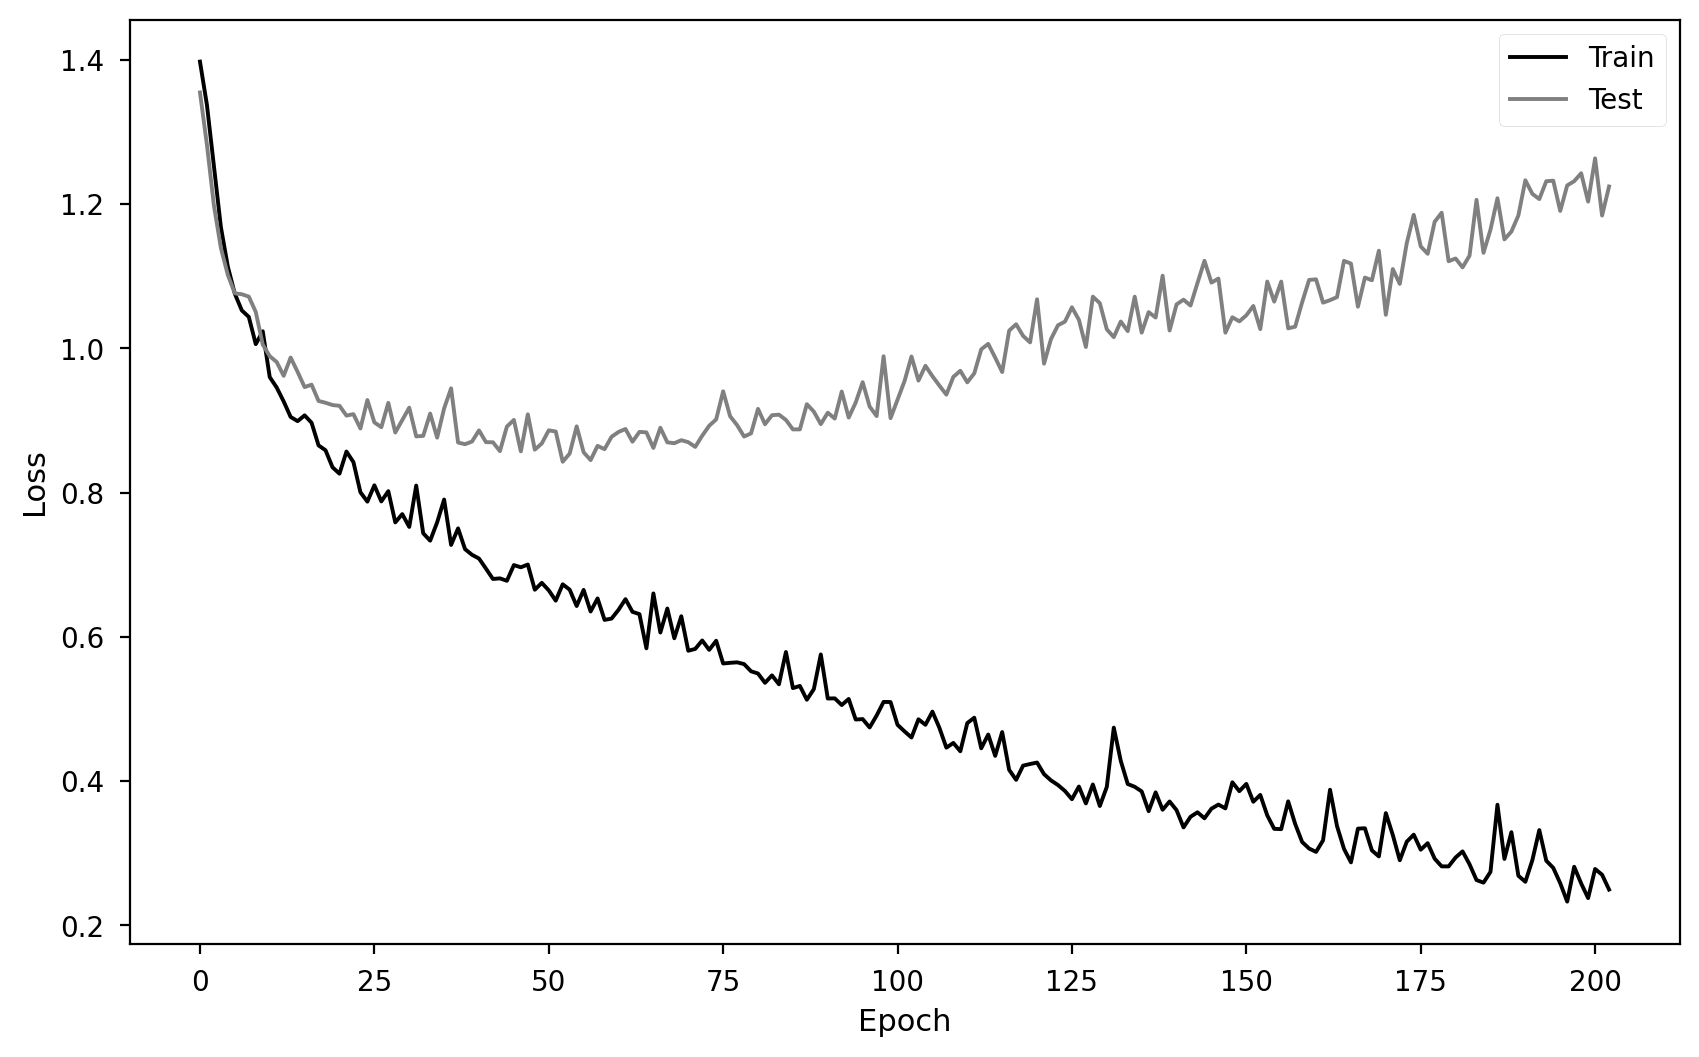

In [34]:
# Create a standalone plot for loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train', color='black')
plt.plot(history.history['val_loss'], label='Test', color='gray')
#plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(img_path / "tf_loss.png", format="png", dpi=400, bbox_inches="tight")
print(f"Plot saved to: {img_path / 'tf_loss.png'}")

Plot saved to: ../img/L_540_2022_CERB/tf_conf.png


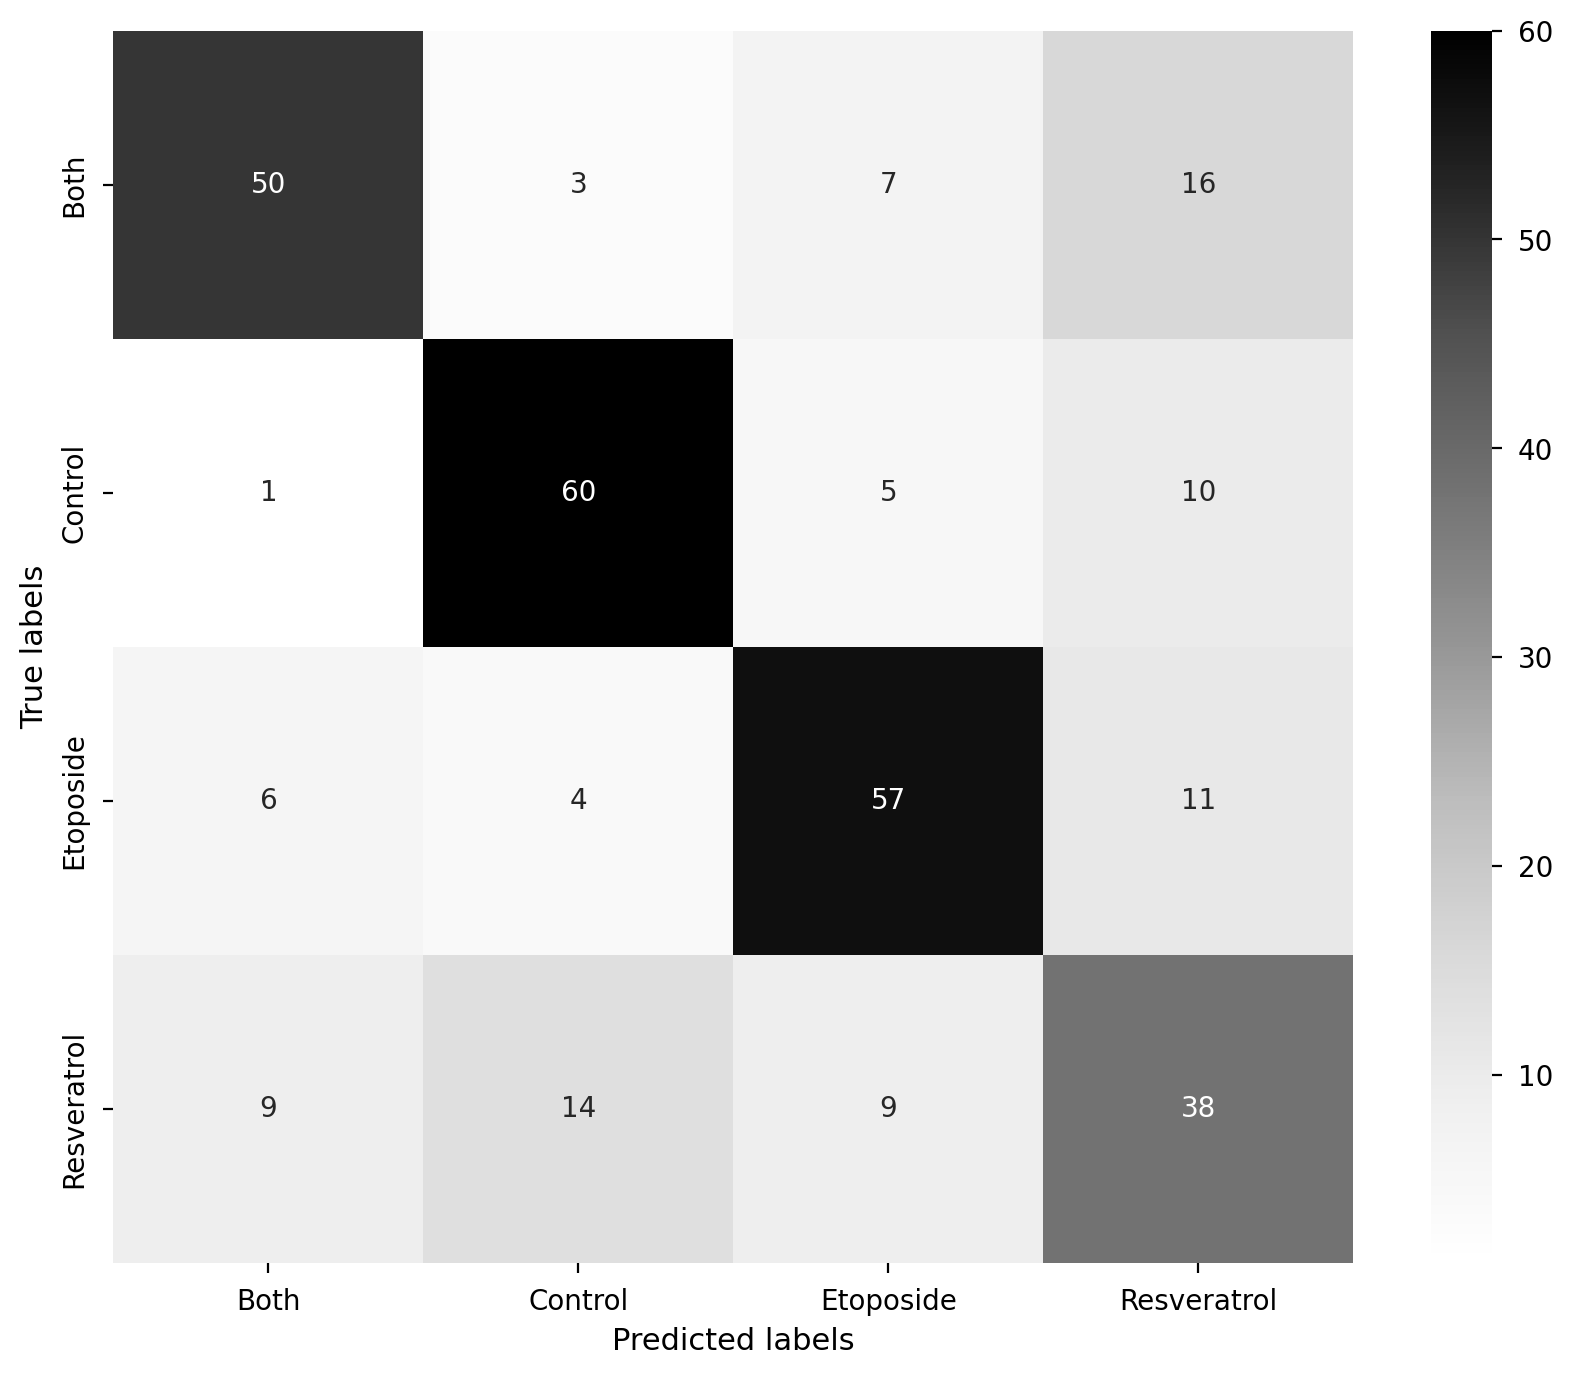

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Greys', 
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
#plt.title('Confusion Matrix')
plt.savefig(img_path / "tf_conf.png", format="png", dpi=400, bbox_inches="tight")
print(f"Plot saved to: {img_path / 'tf_conf.png'}")

In [42]:
uniqe_labels

array([0, 1, 2, 3])

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       0.76      0.66      0.70        76
           1       0.74      0.79      0.76        76
           2       0.73      0.73      0.73        78
           3       0.51      0.54      0.52        70

    accuracy                           0.68       300
   macro avg       0.68      0.68      0.68       300
weighted avg       0.69      0.68      0.68       300



Plot saved to: ../img/L_540_2022_CERB/tf_auc_roc.png
AUC-ROC: 0.8863387555580419


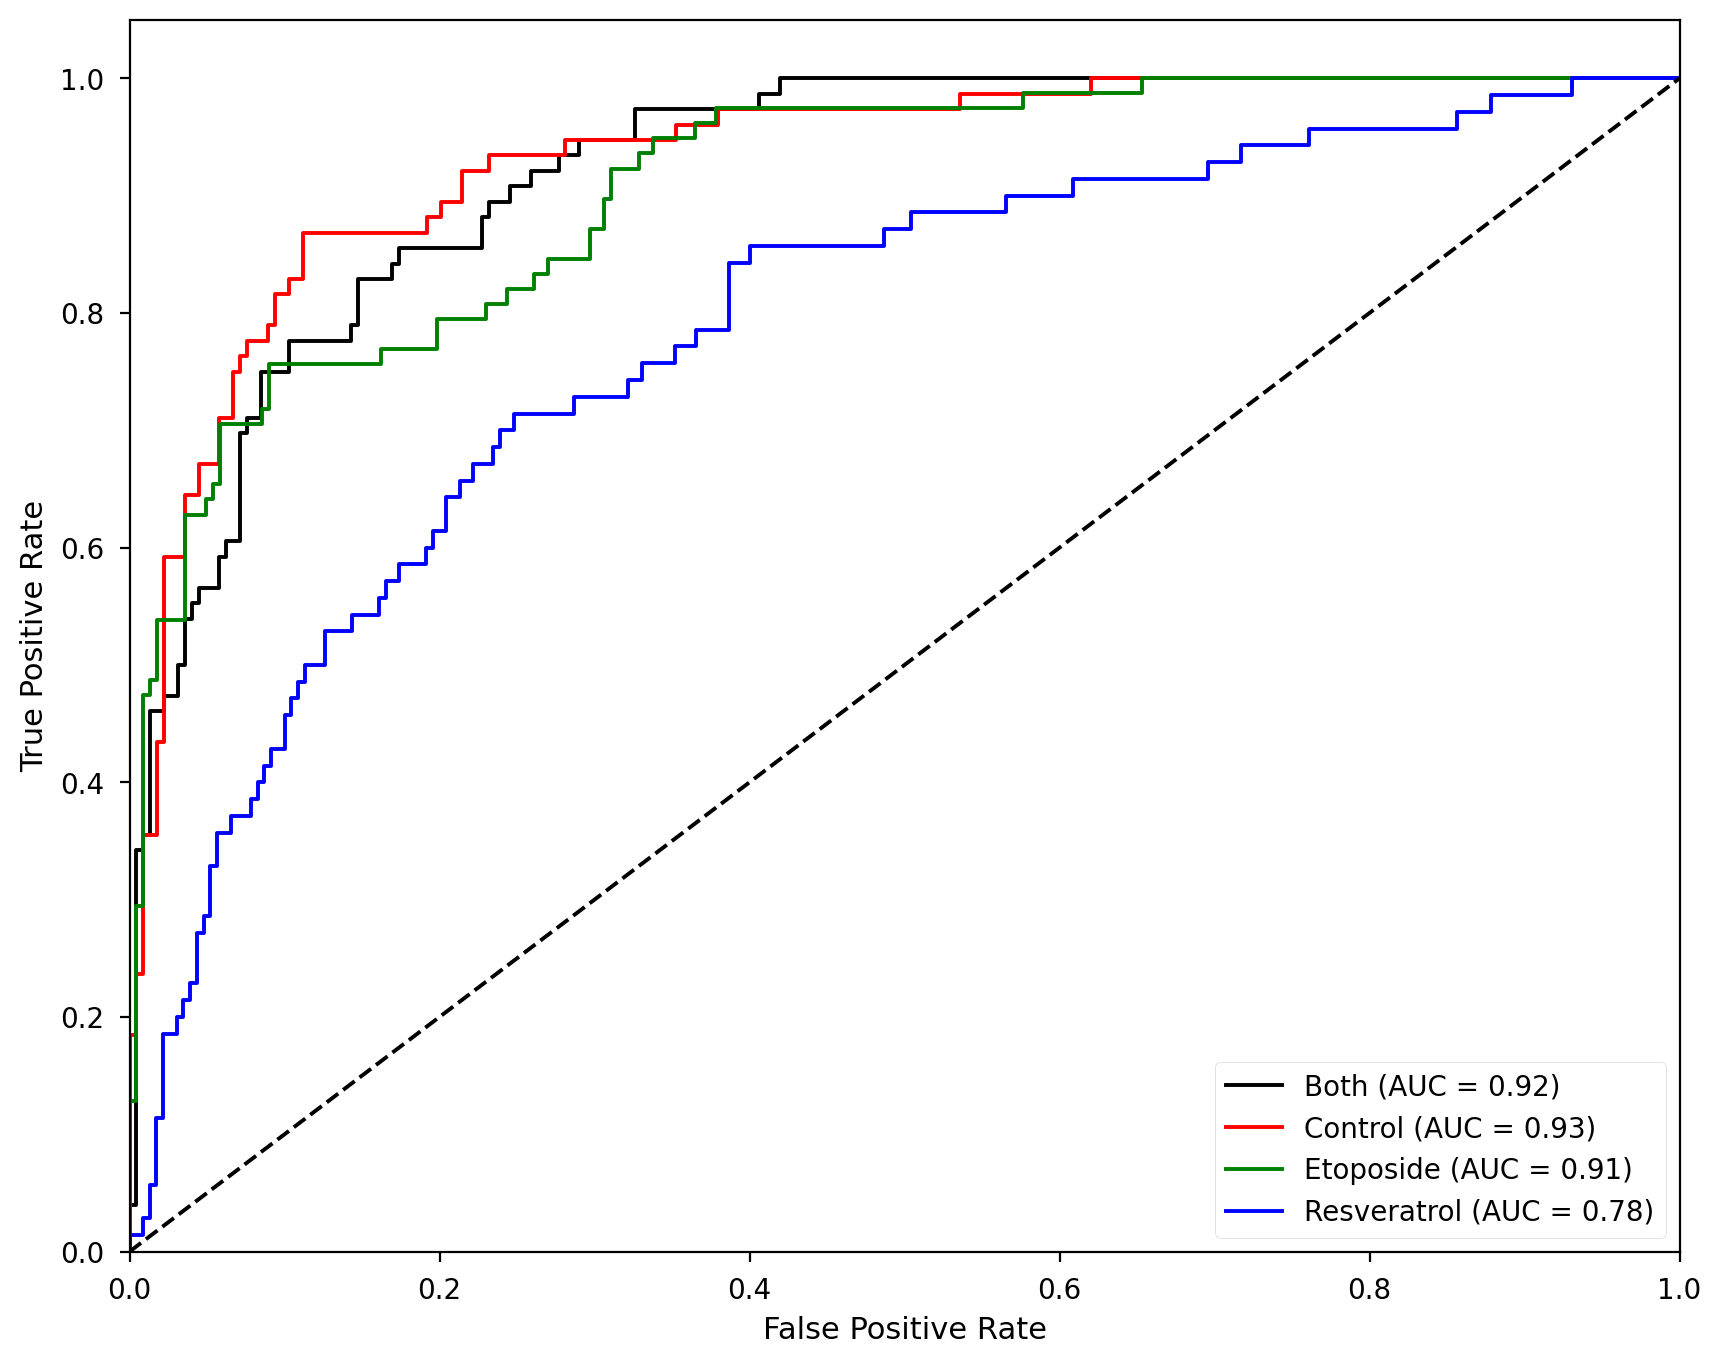

In [51]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Binarize the labels for ROC curve
y_test_binarized = label_binarize(y_true, classes=np.unique(y_true))
y_pred_binarized = y_pred  # Since y_pred is already one-hot encoded

n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

label_to_real_name = {0: "Both", 1: "Control", 2: "Etoposide", 3: "Resveratrol"}

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['black', 'red', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    real_class_name = label_to_real_name[unique_labels[i]]
    plt.plot(fpr[i], tpr[i], label=f'{real_class_name} (AUC = {roc_auc[i]:.2f})', color=color)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (One-vs-All)')
plt.legend(loc="lower right")
plt.savefig(img_path / "tf_auc_roc.png", format="png", dpi=400, bbox_inches="tight")
print(f"Plot saved to: {img_path / 'tf_auc_roc.png'}")

roc_auc_score_value = roc_auc_score(y_test_binarized, y_pred_binarized, multi_class='ovr')
print("AUC-ROC:", roc_auc_score_value)




Plot saved to: ../img/L_540_2022_CERB/tf_precision_recall.png


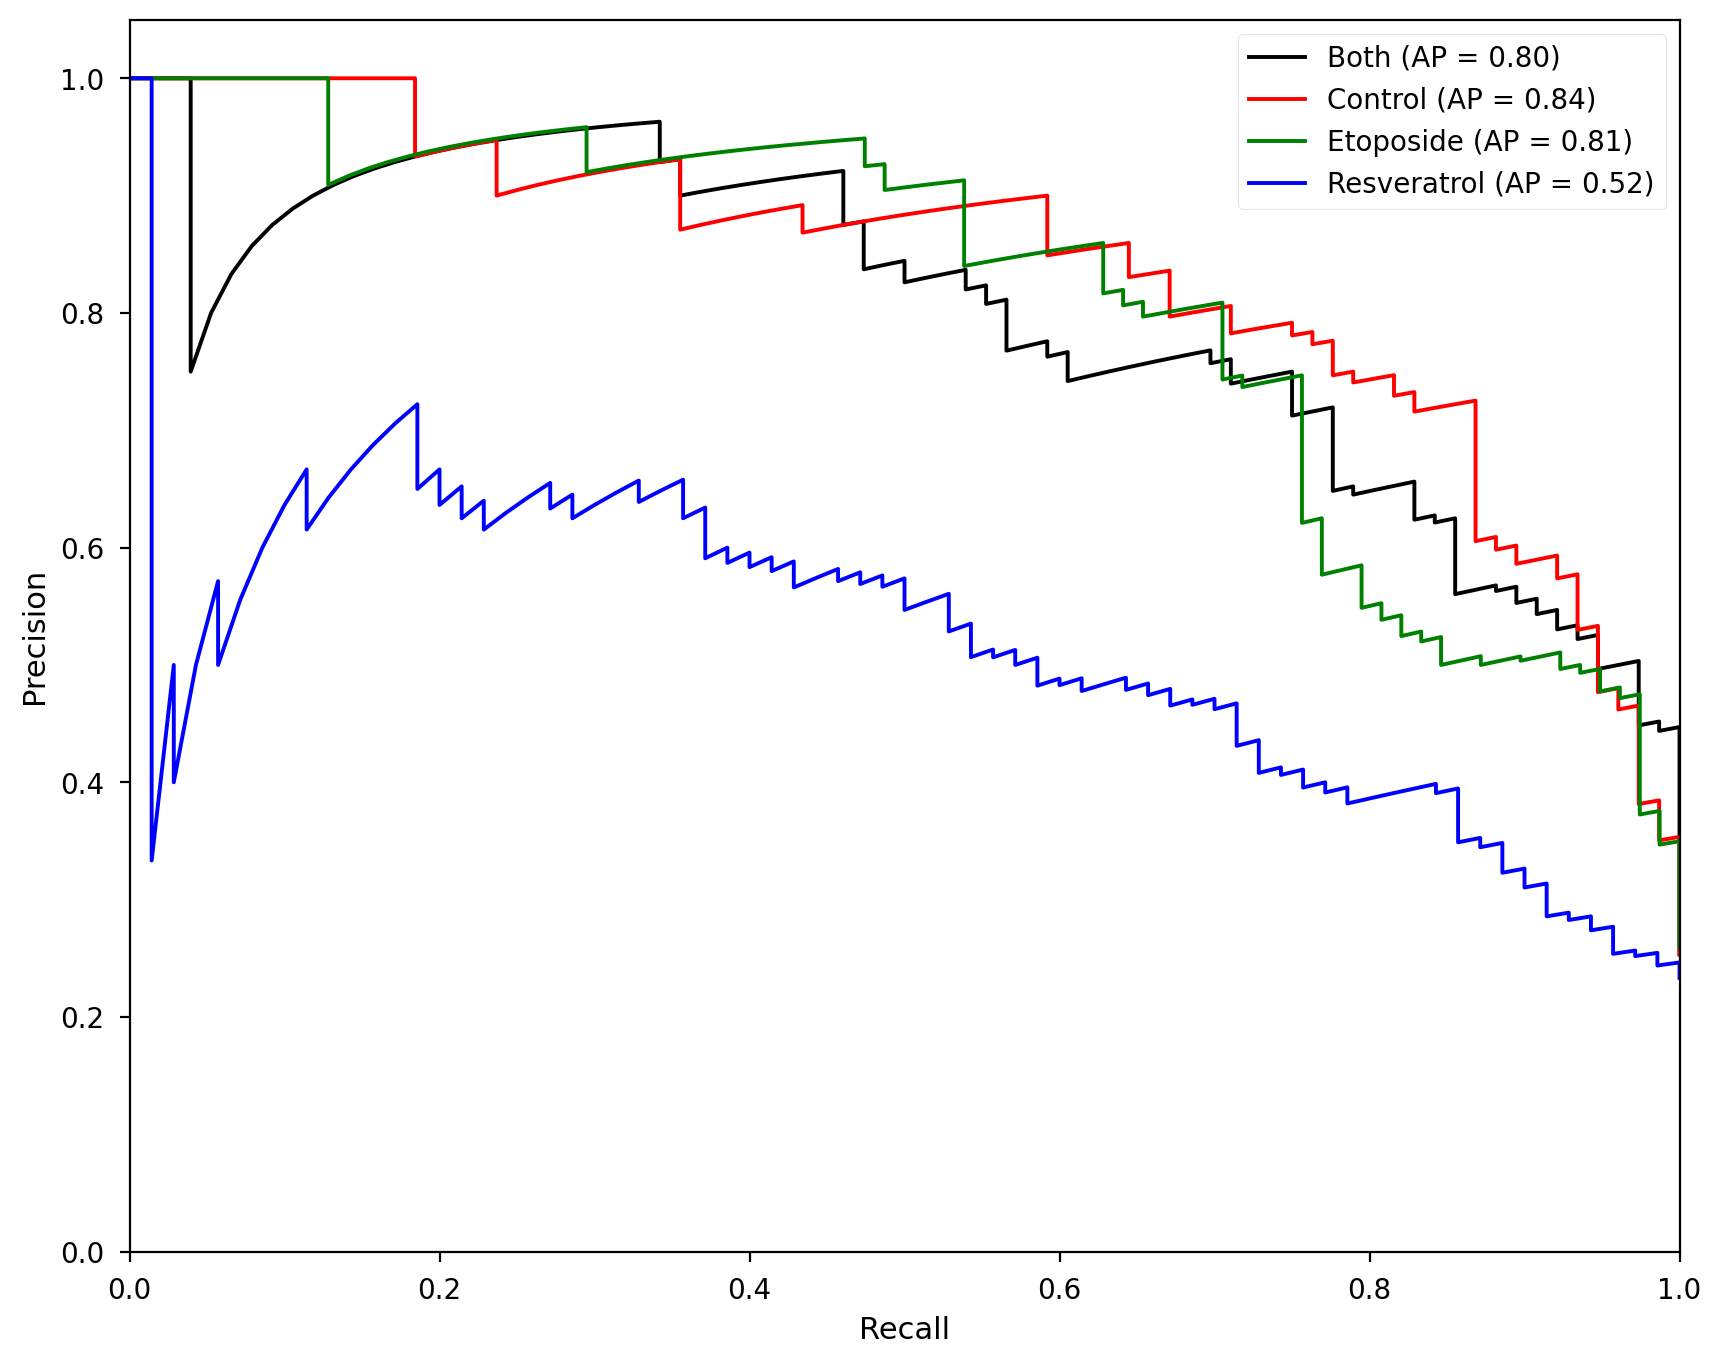

In [50]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for Precision-Recall curve
y_test_binarized = label_binarize(y_true, classes=np.unique(y_true))
y_pred_binarized = y_pred  # Since y_pred is already one-hot encoded

n_classes = y_test_binarized.shape[1]

# Compute Precision-Recall and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_binarized[:, i])

label_to_real_name = {0: "Both", 1: "Control", 2: "Etoposide", 3: "Resveratrol"}

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
colors = ['black', 'red', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    real_class_name = label_to_real_name[unique_labels[i]]
    plt.plot(recall[i], precision[i], label=f'{real_class_name} (AP = {average_precision[i]:.2f})', color=color)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.title('Precision-Recall Curve (One-vs-All)')
plt.legend(loc="upper right")

plt.savefig(img_path / "tf_precision_recall.png", format="png", dpi=400, bbox_inches="tight")
print(f"Plot saved to: {img_path / 'tf_precision_recall.png'}")


Augmentation

In [ ]:
def augment_data(X, y, num_augmentations=2, noise_scale=0.015, scale_range=(0.9, 1.1), shift_range=(-20, 20)):
    X_augmented = []
    y_augmented = []
    
    for xi, yi in zip(X, y):
        for _ in range(num_augmentations):
            X_augmented.append(xi)
            y_augmented.append(yi)

            xi_noisy = xi + np.random.normal(0, noise_scale, xi.shape)
            X_augmented.append(xi_noisy)
            y_augmented.append(yi)

            xi_scaled = np.random.uniform(*scale_range)
            xi_scaled *= xi
            X_augmented.append(xi_scaled)
            y_augmented.append(yi)

            xi_shift = np.roll(xi, shift=int(np.random.uniform(*shift_range)))
            X_augmented.append(xi_shift)
            y_augmented.append(yi)
        
    return np.array(X_augmented), np.array(y_augmented)

# Call the function on your data
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

#print(X_train.shape)
#print(X_train_augmented.shape)

In [ ]:
# Define model
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(y_one_hot.shape[1], activation='softmax')  # Number of output neurons equals number of classes in dataset
])

In [ ]:
# Compile model with costom learning rate, default 0.001
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Set up early stopping callback
early_stopping = EarlyStopping(patience=500)
# Train == fit model
history_aug = model.fit(
    X_train_augmented, y_train_augmented, 
    validation_data=(X_test, y_test),
    epochs=1000, 
    batch_size=32, 
    verbose=False, 
    callbacks=[early_stopping]
)
# Evaluate model performance
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2) # verbose2 for clear output
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

In [ ]:
plt.figure(figsize=(12,5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()